<a href="https://colab.research.google.com/github/KirkDCO/HandsOnML_Exercises/blob/main/Ch14_Q10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import pandas as pd  
import matplotlib.pyplot as plt

## Get the training data for Cats vs Dogs

In [ ]:
split = ['train[:75%]', 'train[75%:90%]', 'train[90%:]']
(trainDataset, validDataset, testDataset), info = \
    tfds.load(name = 'cats_vs_dogs', split = split, as_supervised = True, with_info = True)

class_names = info.features['label'].names

# define a preprocessing function to resize the images
# could be used for data augmentation, too
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.vgg19.preprocess_input(resized_image)
  return final_image, label 


trainDataset = trainDataset.map(preprocess).batch(32).prefetch(1)
validDataset = validDataset.map(preprocess).batch(32).prefetch(1)

tstDataset = testDataset
testDataset = testDataset.map(preprocess).batch(32).prefetch(1)
tstDataset = tstDataset.batch(1).prefetch(1)

## Get VGG19 as base model

In [ ]:
# load VGG19 
base_model = keras.applications.VGG19(include_top = False, input_shape = (224, 224, 3))
for layer in base_model.layers:
  layer.trainable = False

model = keras.models.Sequential(
          [base_model,
           keras.layers.Flatten(name = 'Flatten'),
           keras.layers.Dense(512, activation = 'relu', name = 'Dense1'),
           keras.layers.Dense(64, activation = 'relu', name = 'Dense2'),
           keras.layers.Dense(1, activation = 'sigmoid', name = 'Output')
          ])

model.compile(loss = 'binary_crossentropy',
              optimizer = keras.optimizers.Nadam(),
              metrics = ['accuracy'])

# add learning rate scheduling 
def exponential_decay_fn(epoch):
  return 0.001 * 0.1 ** (epoch / 10)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# add early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

# Train

Epoch 1/2
546/546 [==============================] - 239s 411ms/step - loss: 0.3416 - accuracy: 0.9669 - val_loss: 0.0526 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 2/2
546/546 [==============================] - 222s 406ms/step - loss: 0.0229 - accuracy: 0.9938 - val_loss: 0.0669 - val_accuracy: 0.9857 - lr: 7.9433e-04


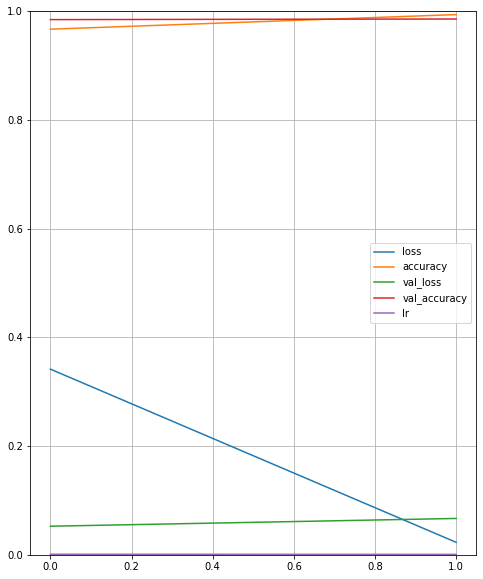

In [ ]:
history = model.fit(trainDataset, 
                    validation_data = validDataset,
                    use_multiprocessing = True,
                    epochs = 2,
                    callbacks = [early_stopping_cb, lr_scheduler])

pd.DataFrame(history.history).plot(figsize = (8, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Save the model

In [ ]:
model.save('drive/MyDrive/Colab Notebooks/HandsOnML/DvC_VGG19_basic')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/HandsOnML/DvC_VGG19_basic/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/HandsOnML/DvC_VGG19_basic/assets


## Reload the saved model 

In [ ]:
model = keras.models.load_model('drive/MyDrive/Colab Notebooks/HandsOnML/DvC_VGG19_basic')

## Evaluate predictions on the test set

In [ ]:
model.evaluate(testDataset)

73/73 [==============================] - 39s 347ms/step - loss: 0.0527 - accuracy: 0.9875


[0.05265505611896515, 0.9875322580337524]

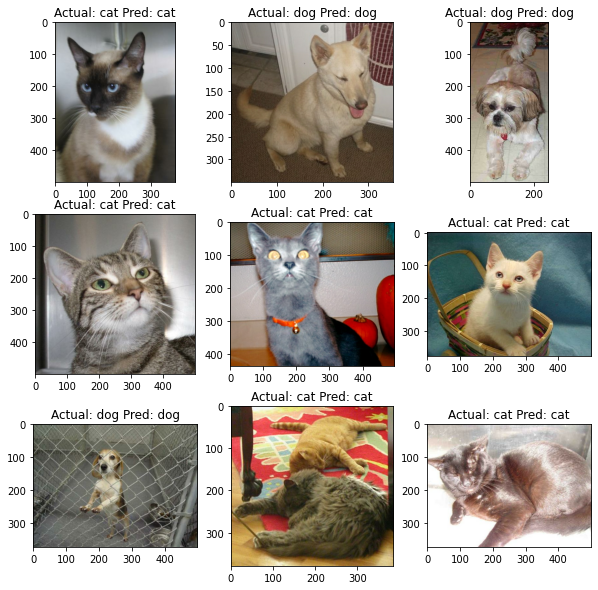

In [ ]:
# plot first few images with labels and predictions

imgs = [i for i,l in tstDataset]
lbls = [class_names[int(l)] for i,l in tstDataset]

preds = model.predict(testDataset)
prds = [class_names[float(p) > 0.5] for p in preds]

plt.rcParams["figure.figsize"] = (10,10)
for i in range(9):
  ax = plt.subplot(330 + 1 + i)
  ax.set_title('Actual: ' + lbls[i] + ' Pred: ' + prds[i])
  ax.imshow(imgs[i][0])

plt.show()

# What the heck is Einstein doing in the set of images??

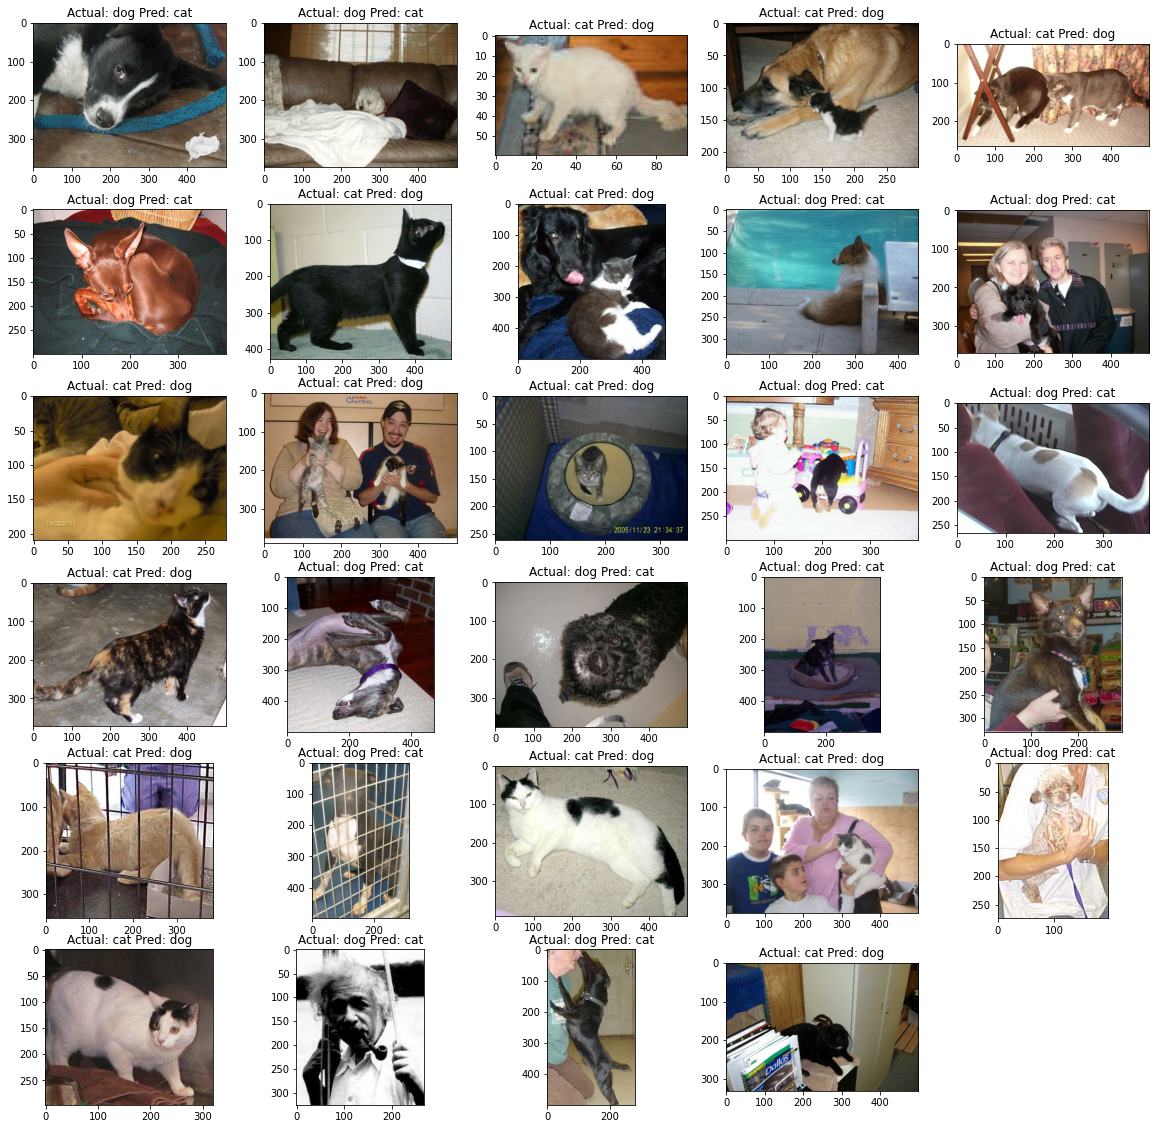

In [ ]:
# plot mislabelled images

idx = [i for i, l in enumerate(lbls) if lbls[i] != prds[i]]
plt.rcParams["figure.figsize"] = (20,20)
for i in range(29):
  ax = plt.subplot(6, 5, 1 + i)
  ax.set_title('Actual: ' + lbls[idx[i]] + ' Pred: ' + prds[idx[i]])
  ax.imshow(imgs[idx[i]][0])

plt.show()

## ???

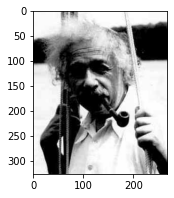

In [ ]:
# Einstein??

plt.rcParams["figure.figsize"] = (3,3)
plt.imshow(imgs[1968][0])

plt.show()